# Cross Cryptocurrency Response Function

In [1]:
import pandas as pd
import dask
import numpy as np
import matplotlib.pyplot as plt
#import cycler, math

from datetime import datetime, timedelta
%matplotlib inline

## I - Load aggregated data

In [3]:
symbols = ['ADAUSDT', 'BTCUSDT', 'BNBUSDT', 'DASHUSDT', 'ETHUSDT', 'LINKUSDT', 'LTCUSDT', 'NANOUSDT', 'THETAUSDT', 'XRPUSDT']
symbs, dfs = [], []

for symbol in symbols:
    print(symbol[:-4], end=' ')
    symbs.append(symbol[:-4])
    df = pd.read_parquet('data.nosync/_aggreg/'+symbol+'.pq')
    print(df.shape, end=' - ')
    dfs.append(df[['is_buyer_maker','nb_trade','mid_price','volume_tot']])

ADA (3876151, 6) - BTC (6466922, 6) - BNB (5420005, 6) - DASH (1588643, 6) - ETH (6404237, 6) - LINK (2717785, 6) - LTC (4975254, 6) - NANO (535838, 6) - THETA (1015545, 6) - XRP (4744723, 6) - 

In [9]:
dfs[0]

,is_buyer_maker,nb_trade,mid_price,volume_tot
timestamp,,,,
2018-07-25 00:00:30,False,24,0.173058,56897.7
2018-07-25 00:00:30,True,33,0.173034,49756.8
2018-07-25 00:01:00,False,27,0.172884,77616.3
2018-07-25 00:01:00,True,24,0.172730,72612.6
2018-07-25 00:01:30,False,47,0.173670,185304.6
...,...,...,...,...
2020-12-28 23:59:00,True,82,0.176762,342421.6
2020-12-28 23:59:30,False,52,0.176513,128112.1
2020-12-28 23:59:30,True,92,0.176487,231553.1


`is_buyer_maker = True` $\rightarrow$ a seller has taken the bid price $\rightarrow$ `trade_price = bid_price`

## II - Data Wrangling

To define the response functions, we need for each time step :
1. **Trade signs** 
2. **Price returns**

### 1. Trade signs

We will need one trade sign per time interval. Since we are are conducting the research on the physical time scale, we can use the following trade sign definition proposed in https://arxiv.org/pdf/2010.15105.pdf : 

$$
\varepsilon(t)=\left\{\begin{aligned}
\operatorname{sgn}\left(\sum_{n=1}^{N(t)} \varepsilon(t, n)\right), & \text { If } N(t)>0 \\
0, & \text { If } N(t)=0 \text{ or (total number of buyer trades(}t\text{) = total number of seller trades(}t\text{)) }
\end{aligned}\right.
$$

where : 
- $t$ corresponds to a time step.
- $n$ corresponds to a trade index.
- $\varepsilon(t, n)$ corresponds to the sign of the trade $n$ with respect to the time step $t$.
- $N(t)$ correponds to the number of trades with respect to the time step $t$.

We would like to exclude the response functions where *eps(t)* = 0 like in the paper, as the price responses including them are weaker than the excluding ones (cf section 4.2 https://arxiv.org/pdf/2010.15105.pdf). 

$\varepsilon(t, n)$ can be equal to 0 when either there are no trades within the time step, or when there is the same number of buyer trades and seller trades within a time step.

In [81]:
# Computing the trade sign for each time step according to the above definition
dfs[0][dfs[0].groupby('timestamp').nb_trade.transform(max) == dfs[0].nb_trade].head()

,is_buyer_maker,nb_trade,min_price,max_price,mid_price,volume_tot
timestamp,,,,,,
2018-07-25 00:00:30,True,33,0.17264,0.17349,0.173034,49756.8
2018-07-25 00:01:00,False,27,0.17259,0.17315,0.172884,77616.3
2018-07-25 00:01:30,False,47,0.17315,0.17409,0.173670,185304.6
2018-07-25 00:02:00,False,17,0.17397,0.17427,0.174102,46406.8
2018-07-25 00:02:00,True,17,0.17348,0.17409,0.173824,183567.5


##### Counting *eps(t) = 0* cases

In [65]:
# Counting cases where there are the same number of buyer trades and seller trades within a time step
data_groups = dfs[0].groupby(['timestamp','nb_trade'])
size = data_groups.size().reset_index() 
len(size[size[0] > 1])

179543

In [75]:
# Counting cases where there are no trades within a time step
first_trade = dfs[0].index[0]
last_trade = dfs[0].index[-1]
trade = first_trade
time_steps = dfs[0].index.unique()
idx = 0
missing_time_step = 0
while trade != last_trade : 
    if trade != time_steps[idx]:
        missing_time_step += 1
        idx -= 1
    trade = trade + timedelta(seconds = 30)
    idx += + 1
missing_time_step

307589

Approximately 10% of the time steps gives an $\varepsilon(t) = 0$ for this dataframe, 60% of these being due to some time steps with no trades.

Even if this number isn't tremendous, it would be unfortunate to drop cases where $\varepsilon(t) = 0$ because of the number of buyer trades being equal to the number of seller trades in a given time step, as this leads to a partial loss of information regarding the mid-price within that time step.

We would like to find a solution to this matter.

##### Proposal - Alternative trade sign definition

A better alternative may be to consider that the trade sign for a given time step corresponds to the sign of the type of trades that produced the most volume within the given time step. This way, $\varepsilon(t) = 0$ when either there are no trades within the time step, or when the volume associated with buyer trades is equal to the volume associated with seller trades (which is not likely). 

Moreover, to prevent loss of information regarding the mid-price, for cases where the volume associated with buyer trades is equal to the volume associated with seller trades, we can assume that $\varepsilon(t) = \varepsilon(t - 1)$ as financial markets tend to be highly self-correlated.

For time steps containing no trades, $\varepsilon(t)$ will be equal to 0 and won't be considered for what follows in this project. 

This leads to the following definition of the trade sign:  

$$
\varepsilon(t)=\left\{\begin{aligned}
\operatorname{sgn}\left(
\sum_{n=1}^{N(t)} \varepsilon(t, n)V(t, n)\right), & \text { If } N(t)>0 \\
\varepsilon(t - 1), & \text { If (total volume of buyer trades(}t\text{) = total volume of seller trades(}t\text{)) }\\
0, & \text { If } N(t)=0
\end{aligned}\right.
$$

where : 
- $V(t, n)$ corresponds to the volume of the trade $n$ with respect to the time step $t$.
- $\varepsilon(t, n)$ corresponds to the sign of the trade $n$ with respect to the time step $t$.
- $t$ corresponds to a time step.
- $N(t)$ corresponds to the number of trades with respect to the time step $t$.

Not only is this definition more coherent (it doesn't make sense to say that the trade sign within a time step is positive in the case where there are more buyer trades than seller trades but more total volume for the latter than the former), it will reduce the number of cases where *eps(t)* = 0 since there are less cases where the volume associated to buyer trades is equal with the volume associated to seller trades.

In [11]:
dfs[0][dfs[0].groupby('timestamp').volume_tot.transform(max) == dfs[0].volume_tot]

,is_buyer_maker,nb_trade,mid_price,volume_tot
timestamp,,,,
2018-07-25 00:00:30,False,24,0.173058,56897.7
2018-07-25 00:01:00,False,27,0.172884,77616.3
2018-07-25 00:01:30,False,47,0.173670,185304.6
2018-07-25 00:02:00,True,17,0.173824,183567.5
2018-07-25 00:02:30,True,14,0.173676,57561.3
...,...,...,...,...
2020-12-28 23:58:00,True,141,0.177031,456036.9
2020-12-28 23:58:30,False,95,0.176671,309831.9
2020-12-28 23:59:00,True,82,0.176762,342421.6


##### Counting *eps(t) = 0* cases

In [84]:
# Counting cases where there the volume associated with buyer / seller trades is identical
data_groups = dfs[0].groupby(['timestamp','volume_tot'])
size = data_groups.size().reset_index() 
len(size[size[0] > 1])

916

With the first definition of trade signs, there are approximately 180k cases where there are the same number of buyer trades and seller trades within a time step. 

With this second definition, we successfully reduced the number of cases where *eps(t)* = 0 by approximately **179k** for this dataset.

### 2. Price returns

We assume that the mid-price of a cryptocurrency for a time step is equal to : *mean of buyer trades + mean of seller trades / 2*

**TODO : [Explain more how we made that choice in the report]**

In [88]:
dfs[0]['mid_price'].groupby('timestamp').mean().head()

timestamp
2018-07-25 00:00:30    0.173046
2018-07-25 00:01:00    0.172807
2018-07-25 00:01:30    0.173655
2018-07-25 00:02:00    0.173963
2018-07-25 00:02:30    0.173849
Name: mid_price, dtype: float64

##### Definition 1

We can compute the midpoint price return with the following definition :

$$
r(t, \tau)=\frac{m(t+\tau)-m(t)}{m(t)}
$$

where : 
- $t$ corresponds to a time step.
- $\tau$ corresponds to a time lag.
- $m(t)$ correponds to the mid price with respect to the time step $t$.

For this whole section, we will choose $\tau$ to be equal to one time step (=30s).

In [328]:
def price_return(df, tau = 1):
    return (df.mid_price.shift(-tau) - df.mid_price)/df.mid_price

##### Definition 2

We can also compute the midpoint price return with the following definition :

$$
r(t, \tau)= \ln \frac{m(t+\tau)}{m(t)}
$$

where : 
- $t$ corresponds to a time step.
- $\tau$ corresponds to a time lag.
- $m(t)$ corresponds to the mid price with respect to the time step

In [331]:
def log_price_return(df, tau = 1):
    return np.log(df.mid_price.shift(-tau)/df.mid_price)

### 3 - Wrangling all the data

In [149]:
# Function to wrangle the data with respect to the conclusions that have been specified above. 
def wrangle_data(df_origin):
    
    # Copying the dataframe to avoid modifying it directly
    df = df_origin.copy()
    
    # Adding the trade sign column
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1) 
    
    # Computing the indexes corresponding to the maximum total volume for each time step
    indexes = df.groupby('timestamp').volume_tot.transform(max) == df.volume_tot
    
    # Computing the mid price for each time step
    df['mid_price'] = df['mid_price'].groupby('timestamp').mean()
    
    # To be uncommented if needed - however, it is not really correct to affect 
    # a trading sign to an aggregation of number of trades & total volume of buyer & seller trades combined
    #df['nb_trade'] = df['nb_trade'].groupby('timestamp').sum()
    #df['volume_tot'] = df['volume_tot'].groupby('timestamp').sum()
    
    # Filtering columns - to be commented & replaced by what's below if needed
    df = df[['trade_sign','mid_price']]
    #df = df[['trade_sign','mid_price','nb_trade','volume_tot']]
    
    # Keeping only the indexes computed above
    df = df[indexes]
    
    # Find indexes of rows corresponding to the time steps where
    # total volume of buyer trades = total volume of seller trades (they weren't filtered out above)
    indexes_eps0 = df.index.duplicated(keep="first")
    
    # Changing the trade_sign of these indexes to NaN
    df.loc[indexes_eps0,'trade_sign'] = None
    
    # Dropping the duplicate row
    df = df.groupby(df.index).first()
    
    # Forward filling the trade sign by the trade sign above
    df = df.ffill()
    
    # Dropping NaNs in case there is a NaN in the first row, in which case it wouldn't benefit from the forward filling
    df = df.dropna()    
    
    return df

In [161]:
dfs_ = []
for df in dfs :
    dfs_.append(wrangle_data(df))
dfs = dfs_

## III - Self-response function

In this third section, we will analyze the self-response function for each cryptocurrency. We will use the following definition, as suggested in https://arxiv.org/pdf/2010.15105.pdf, to compute this quantity :

$$
R(\tau)=E\left[\varepsilon(t)\left (r(t-1, \tau\right))\right]
$$

where : 
- $t$ corresponds to a time step.
- $\tau$ corresponds to a time lag.
- $\varepsilon(t)$ corresponds to the trade sign with respect to the time step $t$.
- $r(t, \tau)$ corresponds to the price return with respect to the time step $t$ and the time lag $\tau$.

### 1. Self-response function over 1000 time steps of 30s (over 8 hours)

First, we are going to compute the self-response function  over 1000 time steps, resulting in 1000*30 = 30000, which represents 8 hours.

In [482]:
# Function to compute the self-response function
def compute_self_response(df, tau_max = 1000, dtau = 1):
    taus = range(1, tau_max, dtau)
    df_shifted = df.shift(1)
    R = []
    for tau in taus:
        df_price_return_shifted = log_price_return(df_shifted, tau = tau)
        R.append(np.nanmean(df.trade_sign * df_price_return_shifted))
    return np.array(R)

In [415]:
#Optimizing the computation following rules suggested at https://docs.dask.org/en/latest/delayed-best-practices.html
#Results were approximately 2 times slower than without dask

"""
@dask.delayed
def log_price_return(df, tau = 1):
    return np.log(df.mid_price.shift(-tau)/df.mid_price)
"""

"""
@dask.delayed
def nan_mean(df, df_price_return_shifted):
    return np.nanmean(df.trade_sign * df_price_return_shifted)
"""

"""
def compute_self_response(df, tau_max = 1000, dtau = 1):
    taus = range(1, tau_max, dtau)
    df_shifted = df.shift(1)
    R = []
    for tau in taus:
        df_price_return_shifted = log_price_return(df_shifted, tau = dtau*tau)
        response = nan_mean(df, df_price_return_shifted)
        R.append(response)
    return R
"""

"""
import time
start = time.time()
r = dask.compute(compute_self_response(dfs[0][:10000]))
end = time.time()
end-start
"""

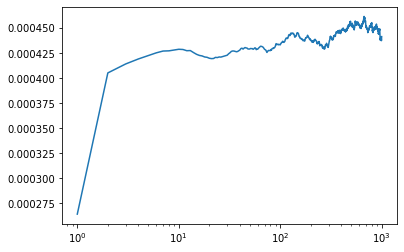

In [546]:
r = compute_self_response(dfs[0])

taus=range(1,1000,1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(taus,r)

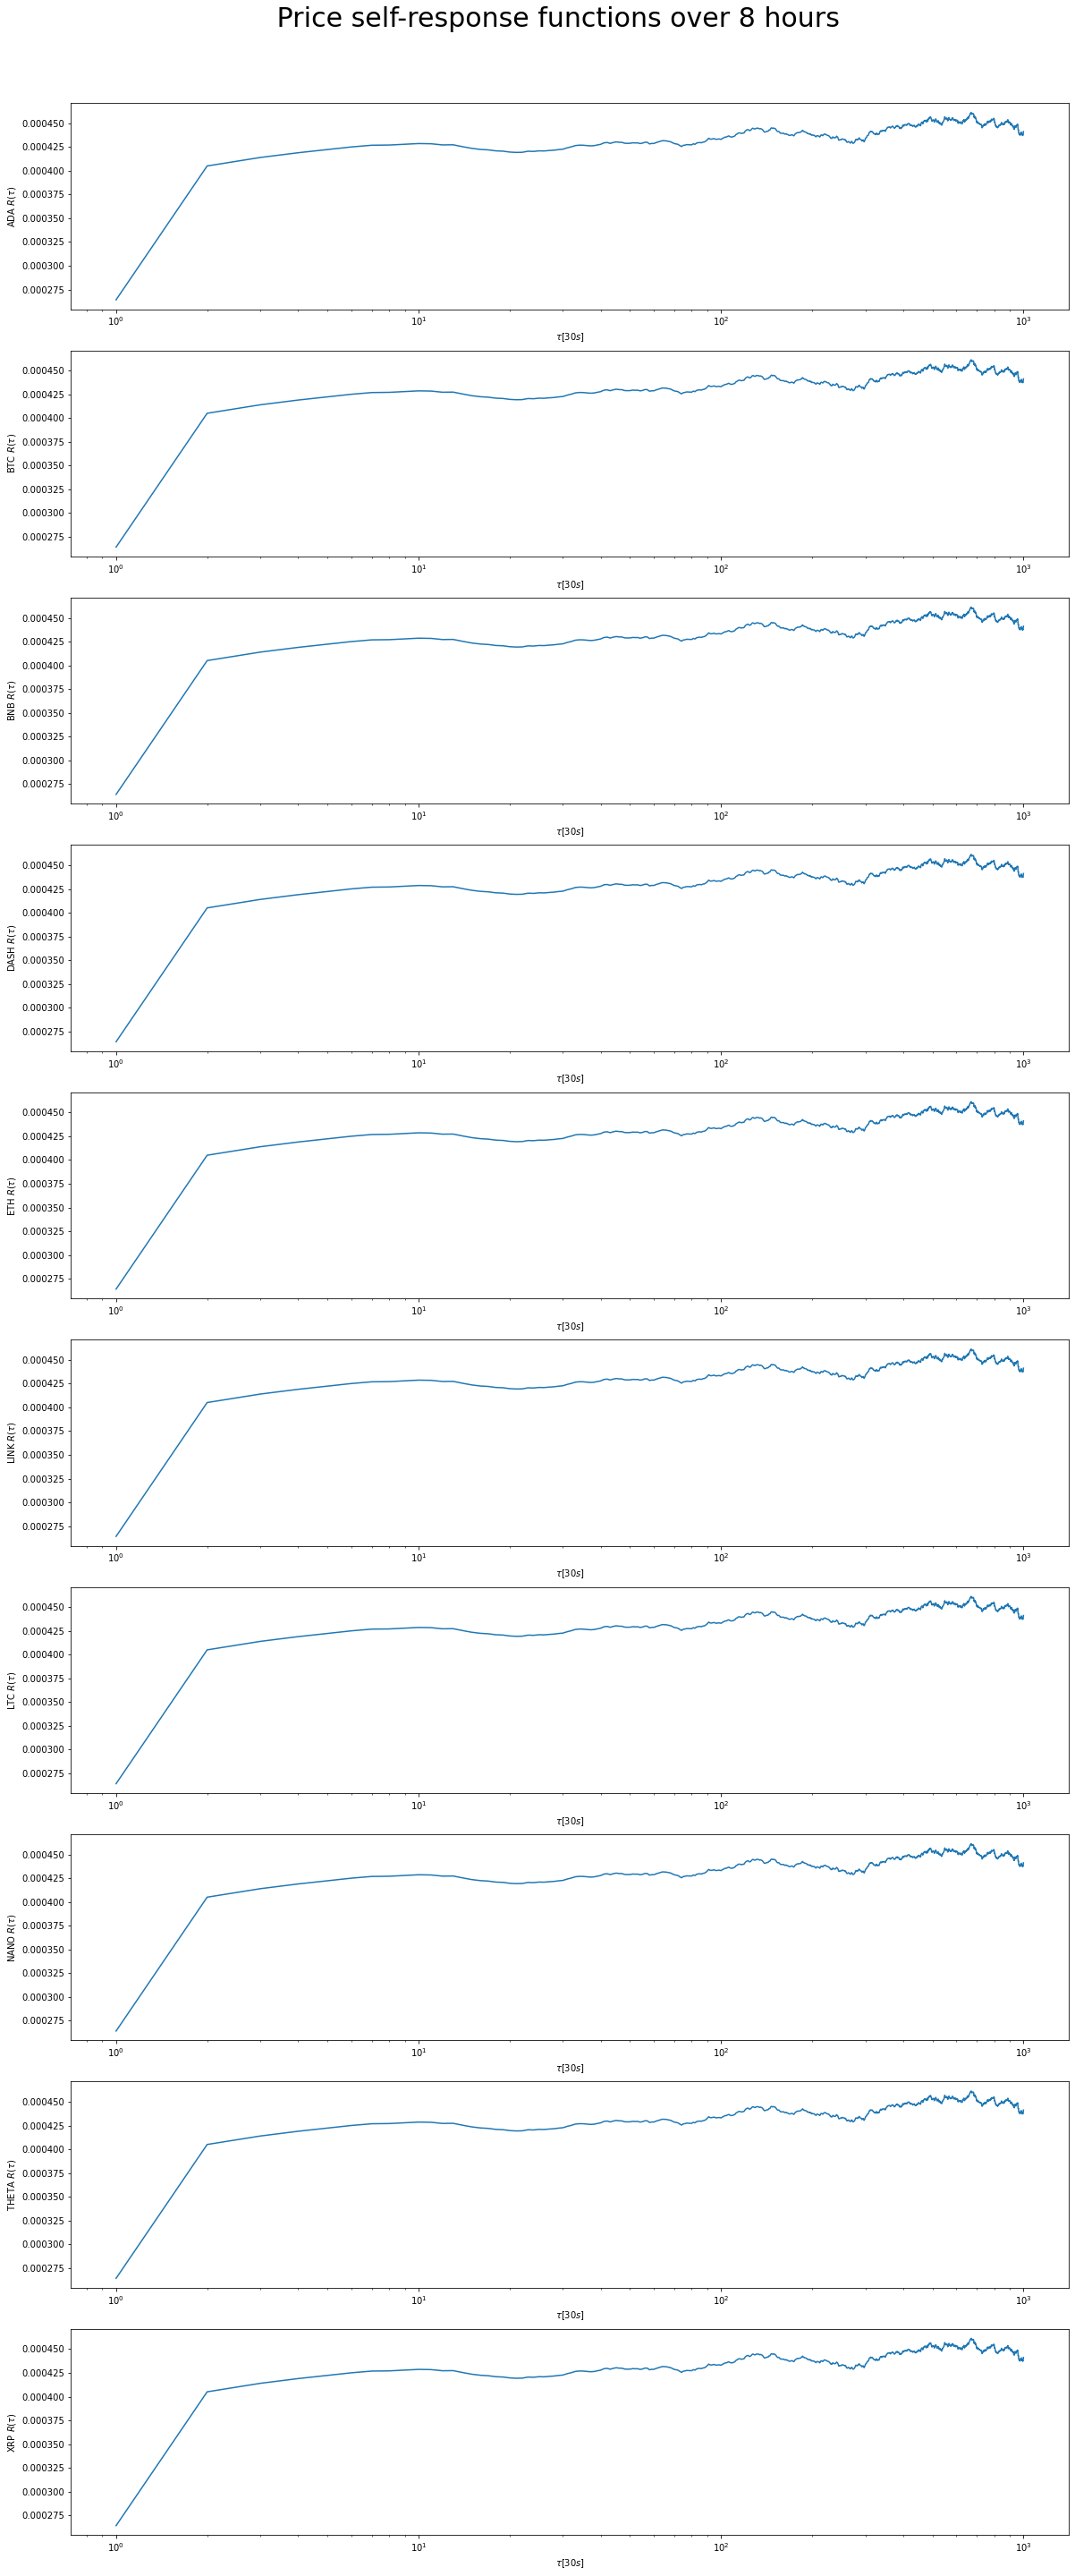

In [549]:
# Computing the self-response functions for each cryptocurrency
rs = [compute_self_response(df, tau_max = 1000, dtau = 1) for df in dfs]

# Plotting the self-response functions over 8 hours for each cryptocurrency
taus=range(1,1000,1)
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50))
for i in range(len(axs)):
    #axs[i].plot(taus, r) # to be removed
    axs[i].plot(taus, rs[i])
    axs[i].set_ylabel(symbs[i]+ ' ' + r'$R(\tau)$')
    axs[i].set_xlabel(r'$\tau[30s]$')
    axs[i].set_xscale('log')
title = ' Price self-response functions over 8 hours'
fig.suptitle(title, fontsize=30, y=0.91)
plt.savefig('images/'+title+'.png', dpi=300)
plt.show()

### 2. Self-response function over a month

Now, we are going to compute the self-response function over 100000 time steps, which represents a month.

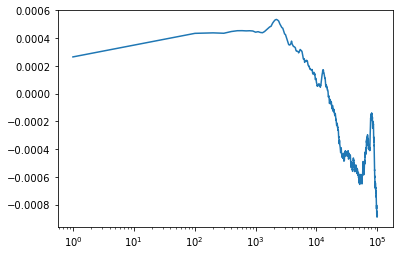

In [509]:
r = compute_self_response(dfs[0], tau_max = 100000, dtau = 100)

taus=range(1,100000,100)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(taus,r)

In [ ]:
# Computing the self-response functions for each cryptocurrency
rs = [compute_self_response(df, tau_max = 100000, dtau = 100) for df in dfs]

# Plotting the self-response functions over a month for each cryptocurrency
taus=range(1,100000,100)
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50))
for i in range(len(axs)):
    #axs[i].plot(taus, r) # to be removed
    axs[i].plot(taus, rs[i])
    axs[i].set_ylabel(symbs[i]+ ' ' + r'$R(\tau)$')
    axs[i].set_xlabel(r'$\tau[30s]$')
    axs[i].set_xscale('log')
title = ' Price self-response functions over a month'
fig.suptitle(title, fontsize=30, y=0.91)
plt.savefig('images/'+title+'.png', dpi=300)
plt.show()

### TODO : On peut commenter pourquoi la response function devient négative - a cause d'un flash crash peut être ? Ou dû à la nature volatile de la cryptomonnaie ?

## IV - Cross-response function

In this fourth section, we will analyze the cross-response function between each combination of cryptocurrencies. We will use the following definition, as suggested in https://arxiv.org/pdf/2010.15105.pdf, to compute this quantity :

$$
R_{i j}(\tau)=E\left[\varepsilon_{j}(t)\left (r_{i}(t-1, \tau\right))\right]
$$

where : 
- $i$ and $j$ each correpond to a cryptocurrency.
- $t$ corresponds to a time step.
- $\tau$ corresponds to a time lag.
- $\varepsilon_{j}(t)$ corresponds to the trade sign of cryptocurrency $j$ with respect to the time step $t$.
- $r_{i}(t, \tau)$ corresponds to the price return of the cryptocurrency $i$ with respect to the time step $t$ and the time lag $\tau$.

We will refer to this function as *cryptocurrency i's cross-response function to cryptocurrency j's trades*.

Similarly to the last part, we are going to visualize this function over 8 hours, and a month, for each combination of cryptocurrencies.

### 1. Cross-response function over 8 hours

In [598]:
# Function to compute the cross-response function
def compute_cross_response(dfi, dfj, tau_max = 1000, dtau = 1):
    taus = range(1, tau_max, dtau)
    dfi_shifted = dfi.shift(1)
    R = []
    for tau in taus:
        df_price_return_shifted = log_price_return(dfi_shifted, tau = tau)
        R.append(np.nanmean(dfj.trade_sign * df_price_return_shifted))
    return np.array(R)

In [599]:
# Function to plot the cross-response functions over a period of time for a combination of cryptocurrencies
def plot_cross_response_function(c_r, i, j, taus):
    fig = plt.figure()
    title =' ' + symbs[i] +"'s price cross-response function to " + symbs[j] +"'s trades"
    fig.suptitle(title, fontsize=15)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_ylabel(r'$R_{'+ symbs[i] + ', '+ symbs[j] + '}'+ r'(\tau)$')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau[30s]$')
    plt.plot(taus,c_r)
    #plt.savefig('images/'+title+'.png', dpi=300)

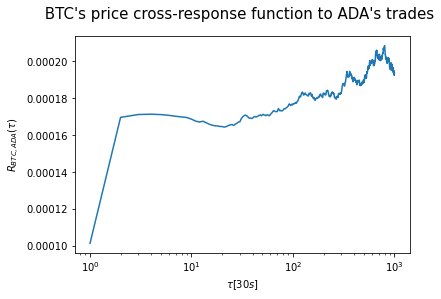

In [543]:
r = compute_cross_response(dfs[1], dfs[0], tau_max = 1000, dtau = 1)
plot_cross_response_function(r, 1, 0, range(1,1000,1))

In [601]:
# Function to plot the cross-response functions over a period of time for
# all the combinations of a given cryptocurrency with every other ones
def plot_all_cross_response_function_for_i(c_rs, i, taus):
    # Plotting the self-response functions over 8 hours for each cryptocurrency
    fig, axs = plt.subplots(nrows=9, ncols=1, figsize=(20, 50))
    for x in range(len(axs)):
        if x<i:
            j = x
        else:
            j = x+1
        axs[x].plot(taus, c_rs[x])
        axs[x].set_ylabel(r'$R_{'+ symbs[i] + ', '+ symbs[j] + '}'+ r'(\tau)$')
        axs[x].set_xlabel(r'$\tau[30s]$')
        axs[x].set_xscale('log')
    title = ' ' + symbs[i] +"'s price cross-response functions to other cryptocurrencies over 8 hours"
    fig.suptitle(title, fontsize=30, y=0.91)
    plt.savefig('images/'+title+'.png', dpi=300)
    plt.show()

In [ ]:
# Computing the cross-response functions of every combinations of cryptocurrencies and saving the plots
for i in range(len(symbs)):
    c_rs = []
    for j in range(len(symbs)):
        if i!=j:
            c_rs.append(compute_cross_response(dfs[i], dfs[j], tau_max = 1000, dtau = 1))
            #c_rs.append(compute_cross_response(dfs[i][-1001:], dfs[j][-1001:], tau_max = 1000, dtau = 1))
    plot_all_cross_response_function_for_i(c_rs, i, range(1,1000,1))

### 2. Cross-response function over a month

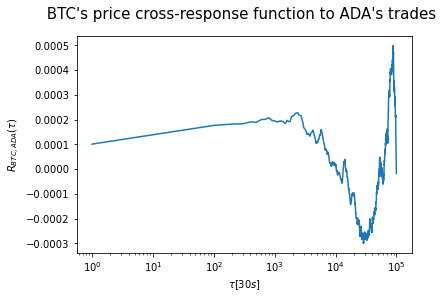

In [603]:
r = compute_cross_response(dfs[1], dfs[0], tau_max = 100000, dtau = 100)
plot_cross_response_function(r, 1, 0, range(1,100000,100))

In [ ]:
# Computing the cross-response functions of every combinations of cryptocurrencies and saving the plots
for i in range(len(symbs)):
    c_rs = []
    for j in range(len(symbs)):
        if i!=j:
            c_rs.append(compute_cross_response(dfs[i], dfs[j], tau_max = 100000, dtau = 100))
    save_plots_of_all_cross_response_function_for_i(c_rs, i, range(1,100000,100))

### TODO : Rapport - faire le lien avec la corrélation en comparant les différents plots

## V - Self- & Cross-response functions during flashcrashes

In this final section we would like to see the behaviour of the above functions during flash crashes.

### I - Flash Crash

In [639]:
# Function to retrieve the rows of a dataframe between the specified dates
def dataframe_range_dates(df, start_date, end_date):
    return df.loc[(df.index > start_date) & (df.index <= end_date)]

<AxesSubplot:xlabel='timestamp'>

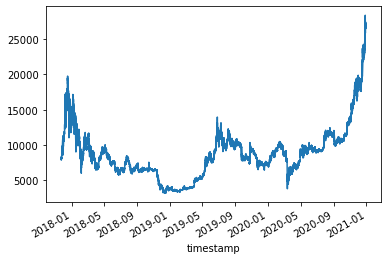

In [638]:
dfs[1]['mid_price'].plot()

In [651]:
btc_flash_crash = dataframe_range_dates(dfs[1], '2020-03-12 00:00:00', '2020-03-13 10:00:00')

<AxesSubplot:xlabel='timestamp'>

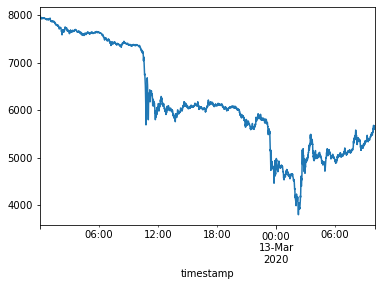

In [652]:
btc_flash_crash['mid_price'].plot()

We can see that the bitcoin suffered two successive flash crashes between the 11th of March 2020 and 15th of March 2020. Let's see how the other cryptocurrencies behaved in that time range.

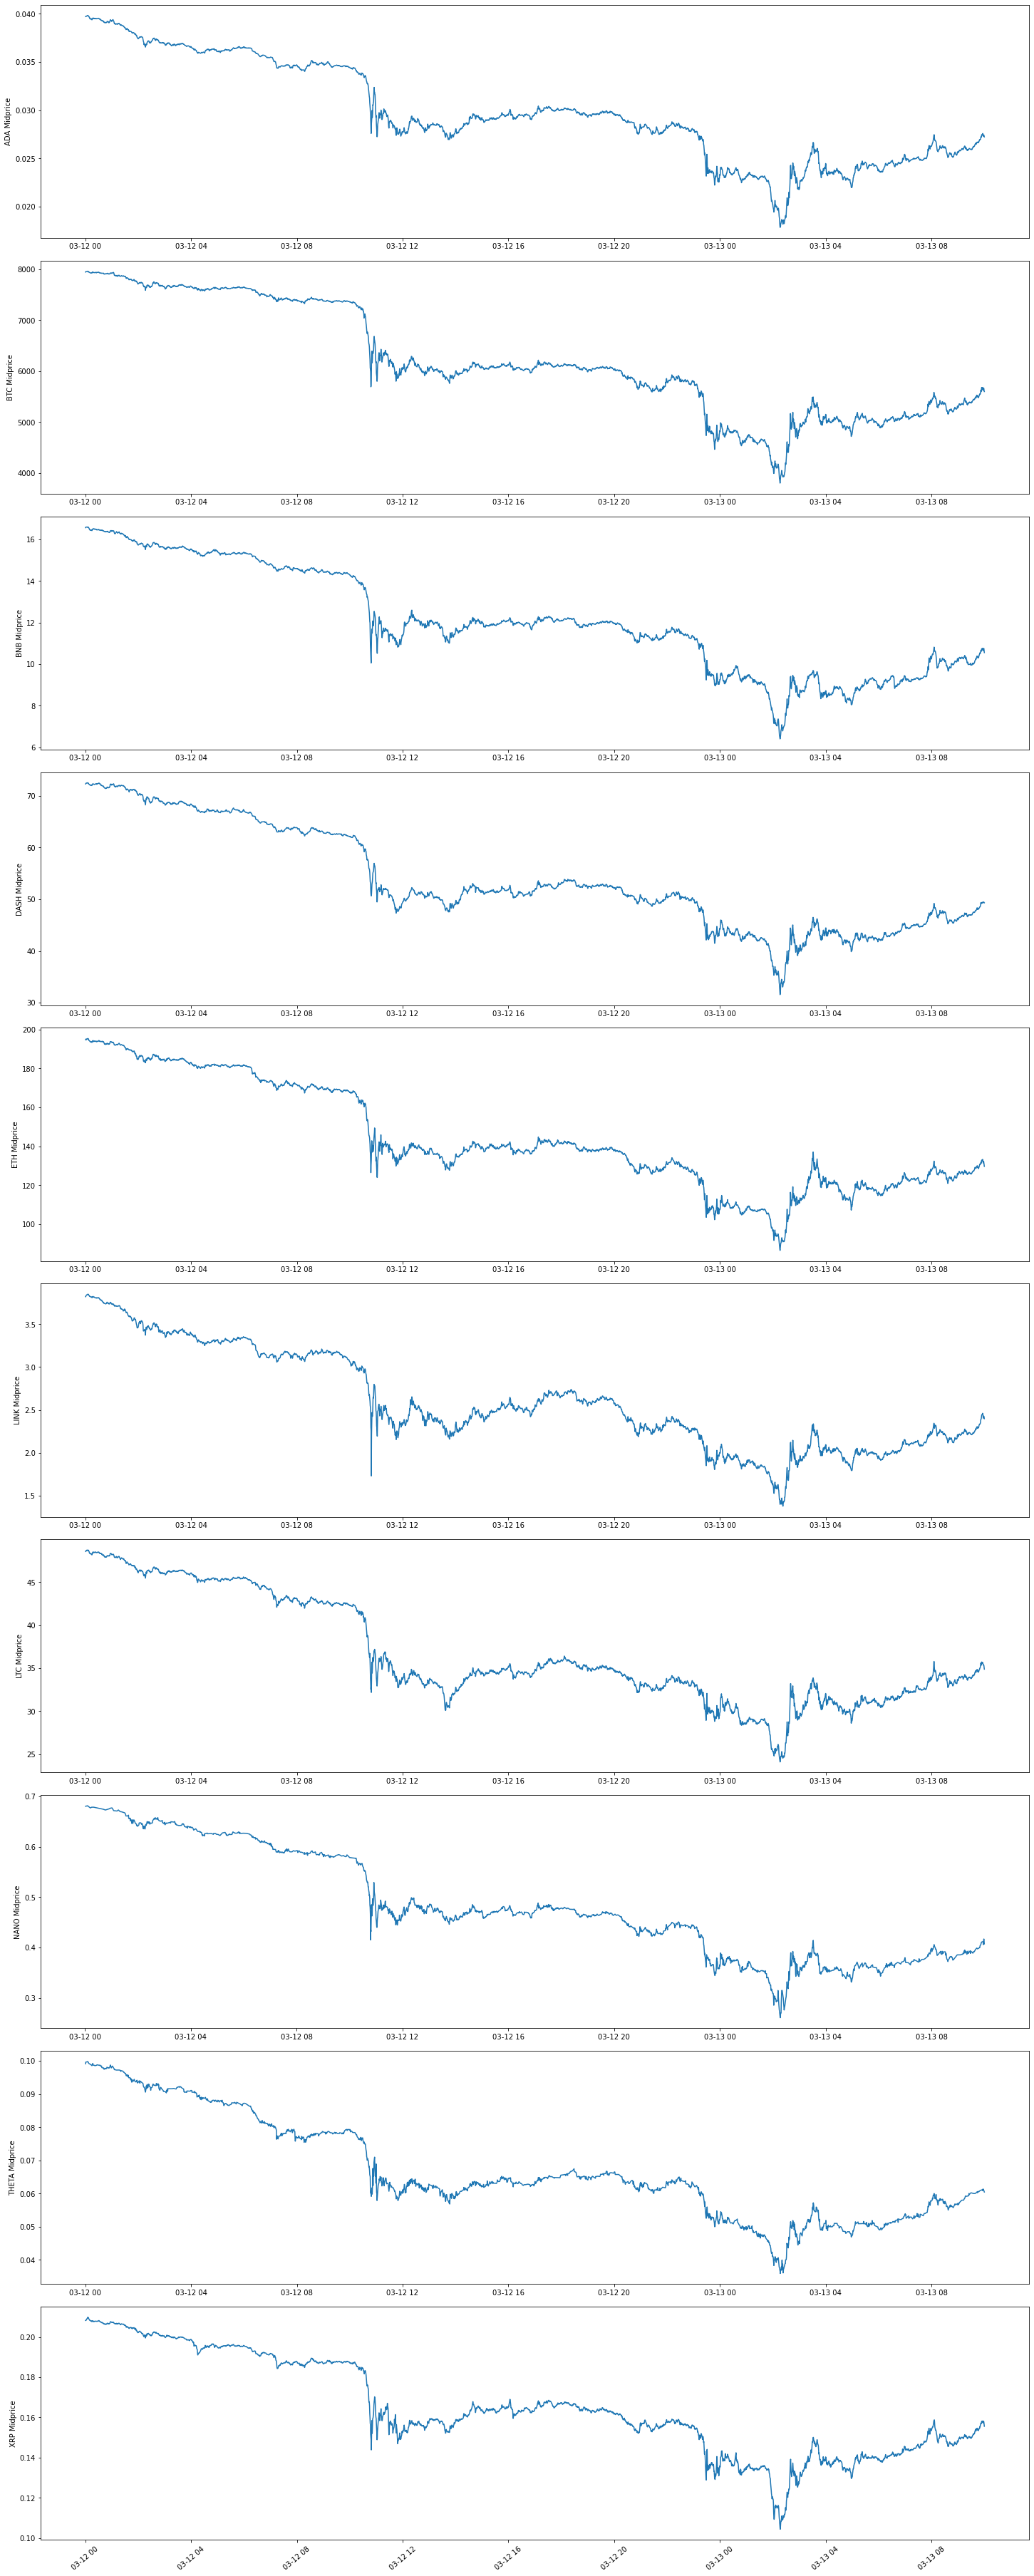

In [653]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50))
fig.tight_layout()

for i in range(len(axs)):
    relevant_df = dataframe_range_dates(dfs[i], '2020-03-12 00:00:00', '2020-03-13 10:00:00')
    axs[i].plot(relevant_df.index, relevant_df['mid_price'])
    axs[i].set_ylabel(symbs[i]+' Midprice')
    plt.xticks(rotation=40)
plt.show()

We can see that all the cryptocurrencies went through a flash crash at the same time.

### II - Self-Response Functions during Flash Crash

Let's dive into the behaviour of the response function in that time frame. 

In [654]:
flash_crash_dfs = [dataframe_range_dates(df, '2020-03-12 00:00:00', '2020-03-13 10:00:00') for df in dfs]

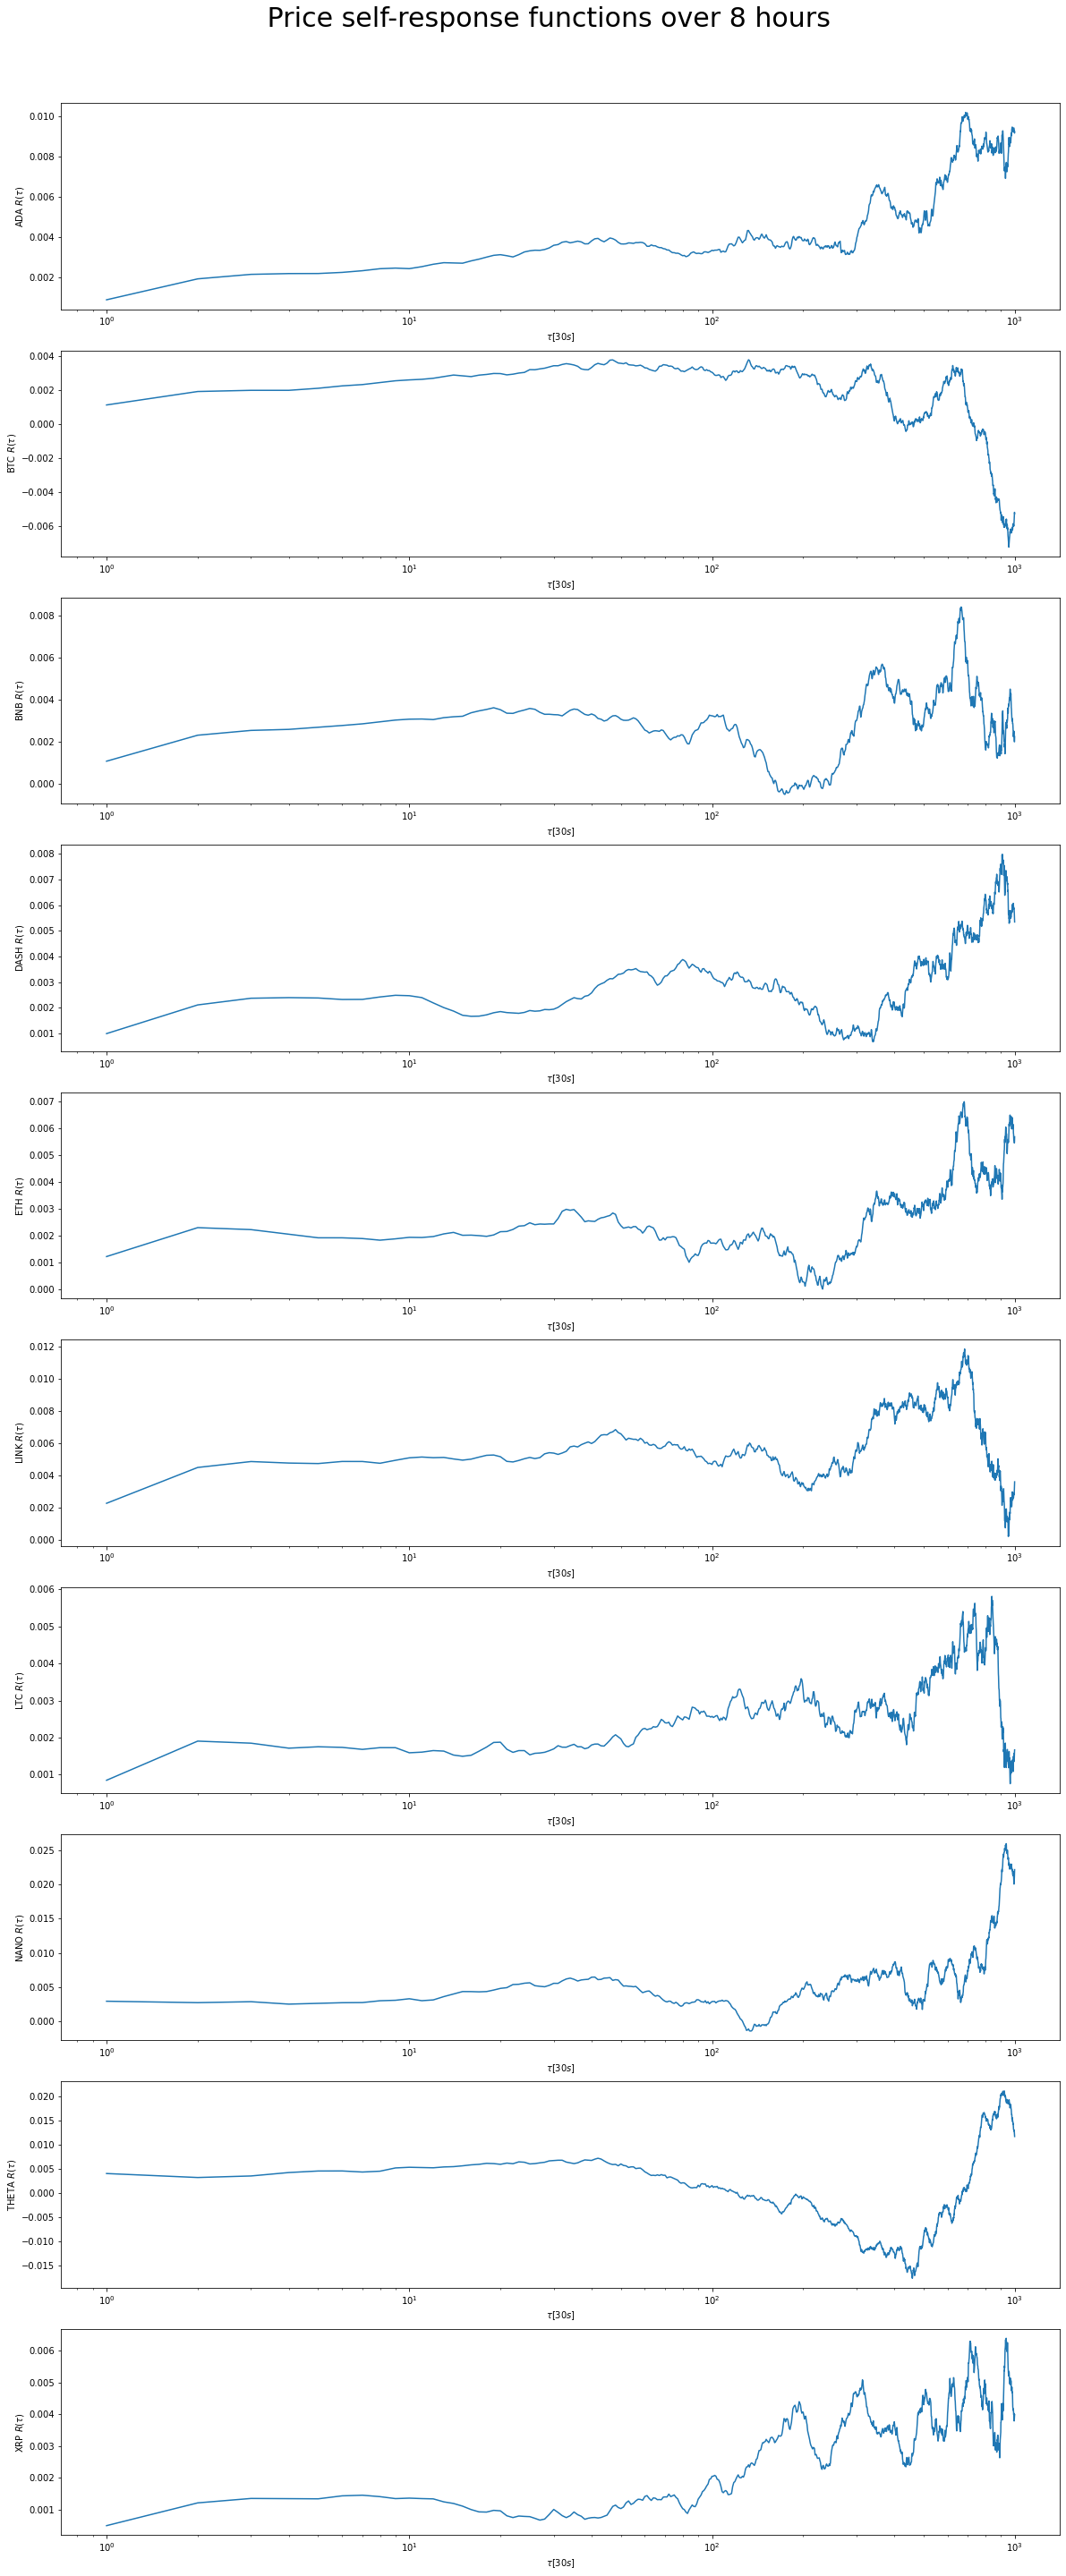

In [655]:
# Computing the self-response functions for each cryptocurrency
flas_crash_rs = [compute_self_response(df, tau_max = 1000, dtau = 1) for df in flash_crash_dfs]

# Plotting the self-response functions over 8 hours for each cryptocurrency
taus=range(1,1000,1)
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50))
for i in range(len(axs)):
    axs[i].plot(taus, flas_crash_rs[i])
    axs[i].set_ylabel(symbs[i]+ ' ' + r'$R(\tau)$')
    axs[i].set_xlabel(r'$\tau[30s]$')
    axs[i].set_xscale('log')
title = ' Price self-response functions over 8 hours'
fig.suptitle(title, fontsize=30, y=0.91)
#plt.savefig('images/'+title+'.png', dpi=300)
plt.show()

### III - Cross-response function during flash-crash

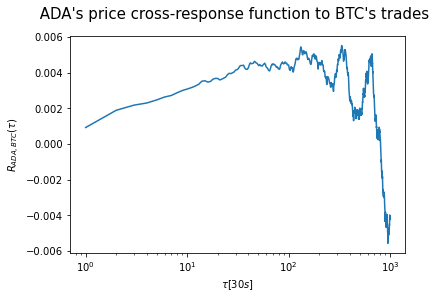

In [658]:
flash_crash_dfs = [dataframe_range_dates(df, '2020-03-12 00:00:00', '2020-03-13 10:00:00') for df in dfs]

# Compute ADA's cross response function to BTC
ada_btc_c_r = compute_cross_response(flash_crash_dfs[0], flash_crash_dfs[1], tau_max = 1000, dtau = 1)

# Plot ADA's cross response function to BTC
plot_cross_response_function(ada_btc_c_r, 0, 1, range(1,1000,1))

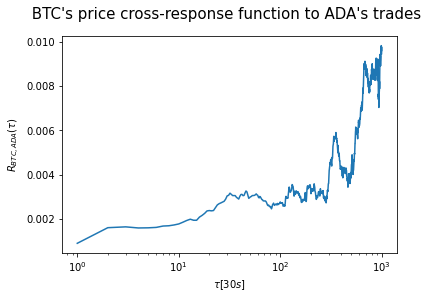

In [660]:
# Compute BTC's cross response function to ADA
btc_ada_c_r = compute_cross_response(flash_crash_dfs[1], flash_crash_dfs[0], tau_max = 1000, dtau = 1)

# Plot BTC's cross response function to ADA
plot_cross_response_function(btc_ada_c_r, 1, 0, range(1,1000,1))

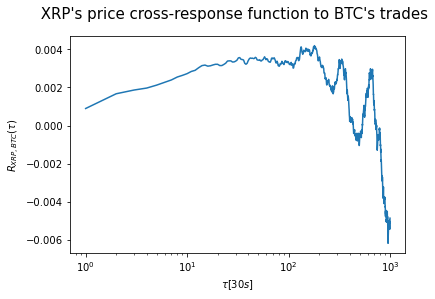

In [663]:
# Compute XRP's cross response function to BTC
xrp_btc_c_r = compute_cross_response(flash_crash_dfs[9], flash_crash_dfs[1], tau_max = 1000, dtau = 1)

# Plot XRP's cross response function to BTC
plot_cross_response_function(xrp_btc_c_r, 9, 1, range(1,1000,1))

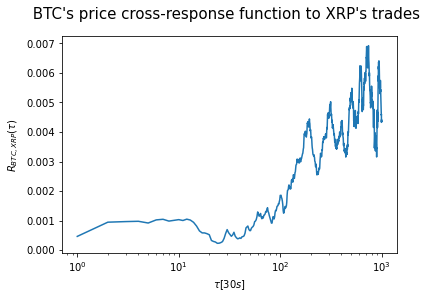

In [664]:
# Compute BTC's cross response function to XRP
btc_xrp_c_r = compute_cross_response(flash_crash_dfs[1], flash_crash_dfs[9], tau_max = 1000, dtau = 1)

# Plot BTC's cross response function to XRP
plot_cross_response_function(btc_xrp_c_r, 1, 9, range(1,1000,1))

## Bonus - Activity self- & cross- response function - est-ce que c'est pertinent ?

Finally, we will analyze the activity self- and cross-response functions. We will use the following definition, as suggested in https://arxiv.org/pdf/2010.15105.pdf, to compute this quantity :